# Fine-Tuning

We fine-tuned multiple language models to specialize them for recipe-related tasks, as general-purpose models often struggle with the structured nature of recipes and ingredient constraint, as we will be able to see with Mistral7B.

Fine-tuning adapts pre-trained models to specific tasks by continuing training on domain-specific data. Instead of training from scratch, we leverage existing knowledge and teach models new patterns through supervised learning on curated examples. This process adjusts model weights to better understand recipe formats, ingredient relationships, and cooking instructions.

For each model, we conducted training with two different dataset sizes:

- 1,000 samples: Testing minimum viable training data for task adaptation
- 6,000 samples: Evaluating whether additional training data yields significantly better performance

In first cells bwlow, we elaborate the pre-processed dataset in order to obtain valid formats for fine-tuning operations.

In [ ]:
import pandas as pd
import ast
import random
from tqdm import tqdm
from collections import defaultdict

# Parse string representation of lists
def safe_parse(value):
    try:
        return ast.literal_eval(value)
    except:
        return []

# Load dataset
df = pd.read_csv('/kaggle/input/recipenlg/full_dataset.csv')
df_subset = df.sample(frac=0.05, random_state=42)
df_subset.reset_index(drop=True, inplace=True)

# Format dataset for recipe generation
df_formatted = df_subset.copy()
df_formatted['included'] = df_formatted['NER'].apply(lambda x: [i.strip().lower() for i in safe_parse(x) if i])

# Build ingredient set
all_ingredients = set()
for incl in df_formatted['included']:
    all_ingredients.update(incl)

# Generate excluded ingredients
excluded_cache = {}
def generate_excluded_cached(included):
    key = tuple(sorted(included))
    if key not in excluded_cache:
        excluded_pool = list(set(all_ingredients) - set(included))
        excluded_cache[key] = random.sample(excluded_pool, min(len(included), 3)) if included else []
    return excluded_cache[key]

df_formatted['excluded'] = df_formatted['included'].apply(generate_excluded_cached)

# Create input/output pairs
def build_input_output(row):
    input_text = f"Include: {', '.join(row['included'])} | Exclude: {', '.join(row['excluded'])}"
    ingredients = [i.strip() for i in safe_parse(row.get('ingredients', '[]'))]
    directions = [d.strip() for d in safe_parse(row.get('directions', '[]'))]
    output_text = (
        f"Title: {row.get('title', '')}\n"
        f"Ingredients: {', '.join(ingredients)}\n"
        f"Directions: {' '.join(directions)}"
    )
    return pd.Series({'input': input_text, 'output': output_text})

df_formatted[['input', 'output']] = df_formatted.apply(build_input_output, axis=1)
df_formatted.to_csv("formatted_recipes_full.csv", index=False)

In [ ]:
import pandas as pd
import ast
import random
from tqdm import tqdm
from collections import defaultdict
tqdm.pandas()

# Parse string representation of lists
def safe_parse(value):
    try:
        return ast.literal_eval(value)
    except:
        return []

# Load dataset and take only a random subset
df = pd.read_csv('/kaggle/input/recipenlg/full_dataset.csv')
df_subset = df.sample(frac=0.05, random_state=42)
df_subset.reset_index(drop=True, inplace=True)
print(f"Il sottoinsieme ha {len(df_subset)} elementi")

df_formatted = df_subset.copy()

def build_input_output(row):
    directions_list = safe_parse(row['directions'])
    input_text = ''.join(str(direction) for direction in directions_list)
    
    output_text = f"Title: {row.get('title', '')}"
    return pd.Series({'input': input_text, 'output': output_text})

df_formatted[['input', 'output']] = df_formatted.progress_apply(build_input_output, axis=1)

df_formatted.to_csv("formatted_recipes_title_generation.csv", index=False)

## Title Generation Preprocessing

In [ ]:
import pandas as pd
from datasets import Dataset

# Load prepared data
df = pd.read_csv("formatted_recipes_title_generation.csv")

def clean_and_format_dataset(df):
    formatted_data = []
    for _, row in df.iterrows():
        formatted_data.append({
            "messages": [
                {
                    "role": "user",
                    "content": f"Give a title to this recipe's procedure: {row['input']}"
                },
                {
                    "role": "assistant",
                    "content": row['output']
                }
            ]
        })
    
    return formatted_data

# Create formatted dataset
formatted_data = clean_and_format_dataset(df)
dataset = Dataset.from_list(formatted_data)

# Split into train/validation
train_val_title = dataset.train_test_split(test_size=0.1, seed=42)
train_dataset_title = train_val_title['train']
val_dataset_title = train_val_title['test']

## Recipe Generation Preprocessing

In [ ]:
# Format for model training
import ast
from datasets import Dataset

df = pd.read_csv("formatted_recipes_full.csv")

def clean_and_format_dataset(df):
    def safe_parse(value):
        if isinstance(value, str):
            try:
                return ast.literal_eval(value)
            except:
                return value
        return value
    
    formatted_data = []
    for _, row in df.iterrows():
        included = safe_parse(row['included'])
        excluded = safe_parse(row['excluded'])
        
        if isinstance(included, list):
            included = ', '.join(included)
        if isinstance(excluded, list):
            excluded = ', '.join(excluded)
        
        formatted_data.append({
            "messages": [
                {
                    "role": "user",
                    "content": f"Create a recipe that uses these ingredients: {included} and doesn't use these ingredients: {excluded}"
                },
                {
                    "role": "assistant",
                    "content": row['output']
                }
            ]
        })
    
    return formatted_data

formatted_data = clean_and_format_dataset(df)
dataset = Dataset.from_list(formatted_data)

# Split into train/validation
train_val_recipe = dataset.train_test_split(test_size=0.1, seed=42)
train_dataset_recipe = train_val_recipe['train']
val_dataset_recipe = train_val_recipe['test']

# Models fine-tuning

We have experimented multiple model architectures, training configurations and number of samples used to fine-tuned models to understand their strengths and limitations.

- **FLAN-T5-SMALL**


  Flan T5 Small is a smaller version of the Flan T5 language model (developed by Google), specifically designed to be lightweight and efficient while still providing strong performance on a variety of NLP tasks. It's a fine-tuned model based on the original T5 architecture, making it suitable for applications like translation, question-answering, and text generation. It has 80 million parameters.


- **FLAN-T5-BASE**


  Flan T5 Base model is a state-of-the-art language model developed by Google, fine-tuned on over 1000 additional tasks covering multiple languages. It achieves strong few-shot performance, even compared to much larger models, and is particularly effective in tasks such as reasoning and question answering. It has 250 million parameters

- **Mistral7B**


  Mistral 7B is a 7.3 billion parameter language model developed by Mistral AI, designed for efficient and high-performing natural language processing tasks. It's known for its ability to achieve superior results on various benchmarks, including surpassing other models of similar size, such as Llama 2 13B. Through HuggingFace tokens, can be used without limits.

## Title Generation Models Fine-Tuning

Starting with title generation as it's the simpler task - models need to generate short, descriptive text rather than long structured recipes.

### FLAN-T5-small with 1k Samples

Testing the smallest model first to establish baseline performance with limited data.

In [ ]:
import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, Seq2SeqTrainingArguments, Seq2SeqTrainer
from datasets import Dataset
import pandas as pd
import random

# reducing size of dataset
random.seed(42)
random_indices = random.sample(range(len(train_dataset_title)), min(1000, len(train_dataset_title)))
limited_train_dataset = train_dataset_title.select(random_indices)
val_random_indices = random.sample(range(len(val_dataset_title)), min(200, len(val_dataset_title)))
smaller_val_dataset = val_dataset_title.select(val_random_indices)

# Format the data for T5 (same function as before)
def format_dataset_for_t5(dataset):
    formatted_data = []
    
    for item in dataset:
        recipe_procedure = item["messages"][0]["content"].replace("Give a title to this recipe's procedure: ", "")
        title = item["messages"][1]["content"]
        
        formatted_data.append({
            "input": f"generate title: {recipe_procedure}",
            "target": title
        })
    
    return Dataset.from_pandas(pd.DataFrame(formatted_data))

# Format datasets
train_t5 = format_dataset_for_t5(limited_train_dataset)
eval_t5 = format_dataset_for_t5(smaller_val_dataset)

# Load model and tokenizer
model_id = "google/flan-t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSeq2SeqLM.from_pretrained(model_id)

# Define training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="flan-t5-small-title-checkpoint",
    eval_strategy="steps",
    eval_steps=100,
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=True,
    push_to_hub=False,
    report_to="none"
)

# Create a preprocessing function
def preprocess_function(examples):
    inputs = examples["input"]
    targets = examples["target"]
    
    model_inputs = tokenizer(inputs, max_length=512, truncation=True, padding="max_length")
    labels = tokenizer(targets, max_length=64, truncation=True, padding="max_length")
    
    labels["input_ids"] = [
        [(l if l != tokenizer.pad_token_id else -100) for l in label] 
        for label in labels["input_ids"]
    ]
    
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Process datasets
train_dataset = train_t5.map(preprocess_function, batched=True)
eval_dataset = eval_t5.map(preprocess_function, batched=True)

# Initialize trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer
)

# Train model
trainer.train()
trainer.save_model("flan-t5-small-title-1ksamples")
tokenizer.save_pretrained("flan-t5-small-title-1ksamples")

### FLAN-T5-small with 6k samples

Scaling up the training data to see if more examples improve title quality, given same architecture and parameters.

In [ ]:
import random
# Use larger dataset
random.seed(42)
random_indices = random.sample(range(len(train_dataset_title)), min(6000, len(train_dataset_title)))
limited_train_dataset = train_dataset_title.select(random_indices)
val_random_indices = random.sample(range(len(val_dataset_title)), min(200, len(val_dataset_title)))
smaller_val_dataset = val_dataset_title.select(val_random_indices)

# Format datasets (using same functions as above)
train_t5 = format_dataset_for_t5(limited_train_dataset)
eval_t5 = format_dataset_for_t5(smaller_val_dataset)

# Load model and tokenizer
model_id = "google/flan-t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSeq2SeqLM.from_pretrained(model_id)

# Define training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="flan-t5-small-title-checkpoint",
    eval_strategy="steps",
    eval_steps=100,
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=True,
    report_to="none"
)

# Process datasets
train_dataset = train_t5.map(preprocess_function, batched=True)
eval_dataset = eval_t5.map(preprocess_function, batched=True)

# Initialize trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer
)

# Train model
trainer.train()
trainer.save_model("flan-t5-small-title")
tokenizer.save_pretrained("flan-t5-small-title")

### FLAN-T5-base with 1k samples

We then tried with a larger model, in order to see differences in title generation.

In [ ]:
# Format datasets (using same functions as above)
train_t5 = format_dataset_for_t5(limited_train_dataset) # Using the 1k samples dataset
eval_t5 = format_dataset_for_t5(smaller_val_dataset)

# Load model and tokenizer - using base variant
model_id = "google/flan-t5-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSeq2SeqLM.from_pretrained(model_id)

# Define training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="flan-t5-base-title-checkpoint",
    eval_strategy="steps",
    eval_steps=300,
    learning_rate=5e-5,
    per_device_train_batch_size=12,  # Smaller batch size for larger model
    per_device_eval_batch_size=12,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=True,
    report_to="none"
)

# Process datasets
train_dataset = train_t5.map(preprocess_function, batched=True)
eval_dataset = eval_t5.map(preprocess_function, batched=True)

# Initialize trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer
)

# Train model
trainer.train()
trainer.save_model("flan-t5-base-title-1ksamples")
tokenizer.save_pretrained("flan-t5-base-title-1ksamples")


### FLAN-T5-base with 6k samples

Increased the number of samples.

In [ ]:
# Use larger dataset
random.seed(42)
random_indices = random.sample(range(len(train_dataset_title)), min(6000, len(train_dataset_title)))
limited_train_dataset = train_dataset_title.select(random_indices)
val_random_indices = random.sample(range(len(val_dataset_title)), min(200, len(val_dataset_title)))
smaller_val_dataset = val_dataset_title.select(val_random_indices)

# Format datasets
train_t5 = format_dataset_for_t5(limited_train_dataset)
eval_t5 = format_dataset_for_t5(smaller_val_dataset)

# Load model and tokenizer
model_id = "google/flan-t5-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSeq2SeqLM.from_pretrained(model_id)

# Define training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="flan-t5-base-title-checkpoint",
    eval_strategy="steps",
    eval_steps=100,
    learning_rate=5e-5,
    per_device_train_batch_size=12,
    per_device_eval_batch_size=12,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=True,
    report_to="none"
)

# Process datasets
train_dataset = train_t5.map(preprocess_function, batched=True)
eval_dataset = eval_t5.map(preprocess_function, batched=True)

# Initialize trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer
)

# Train model
trainer.train()
trainer.save_model("flan-t5-base-title")
tokenizer.save_pretrained("flan-t5-base-title")


### Mistral-7B for title generation

Testing whether a much larger, more capable model can excel at this relatively simple task. The question was: "is such a large model too heavy for such a simple task?"

In [ ]:
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from trl import SFTTrainer, SFTConfig
from transformers import BitsAndBytesConfig

# Formatting function for Mistral
def format_chat_for_mistral(example):
    user_message = example["messages"][0]["content"]
    assistant_message = example["messages"][1]["content"]
    
    # Format according to Mistral's chat template
    formatted_text = f"<s>[INST] {user_message} [/INST]\n{assistant_message}</s>"
    return {"text": formatted_text}

# Create smaller dataset version
random.seed(42)
random_indices = random.sample(range(len(train_dataset_title)), min(1000, len(train_dataset_title)))
limited_train_dataset = train_dataset_title.select(random_indices)
val_random_indices = random.sample(range(len(val_dataset_title)), min(50, len(val_dataset_title)))
smaller_val_dataset = val_dataset_title.select(val_random_indices)

# Configure quantization
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

# Load model
model_id = "mistralai/Mistral-7B-Instruct-v0.3"
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map='auto'
)

# Configure LoRA
model = prepare_model_for_kbit_training(model)
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=[
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj",
    ]
)
model = get_peft_model(model, lora_config)

# Initialize trainer
trainer = SFTTrainer(
    model=model,
    processing_class=tokenizer,
    train_dataset=limited_train_dataset,
    eval_dataset=smaller_val_dataset,
    formatting_func=format_chat_for_mistral,
    args=SFTConfig(
        output_dir="Mistral7B-title-1k",
        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        gradient_accumulation_steps=4,
        learning_rate=2e-4,
        num_train_epochs=2,
        logging_steps=10,
        save_steps=100,
        save_total_limit=2,
        eval_strategy="steps",
        eval_steps=200,
        fp16=True,
        optim="paged_adamw_8bit",
        report_to="none",
        max_seq_length=1024,
        packing=False,
        gradient_checkpointing=True,
        gradient_checkpointing_kwargs={"use_reentrant": False},
        dataloader_num_workers=2,
        dataloader_pin_memory=True
    )
)

# Train and save
trainer.train()
trainer.save_model("Mistral7B-title-final-1ksamples")
tokenizer.save_pretrained("Mistral7B-title-final-1ksamples")


## Recipe generation : Models fine-tuning

Moving to the more complex task of generating complete, structured recipes with multiple components.

After testing recipe generation with smaller models (FLAN-T5-small and FLAN-T5-base) and obtaining poor results, we decided to focus exclusively on the larger model: Mistral-7B. The smaller models struggled with the complexity of generating coherent, multi-component recipes that satisfied ingredient constraints.

In this case, followed 3 fine-tuning approaches:
1. Simple input-output pairs without system prompts
2. Basic system prompt added during fine-tuning
3. Sophisticated system prompt, requiring a formatted output too, during fine-tuning

### Mistral-7B standard recipe generation

Baseline Mistral performance without specialized prompting.

In [ ]:
# Formatting function for Mistral
def format_chat_for_mistral(example):
    user_message = example["messages"][0]["content"]
    assistant_message = example["messages"][1]["content"]
    
    # Format according to Mistral's chat template
    formatted_text = f"<s>[INST] {user_message} [/INST]\n{assistant_message}</s>"
    return {"text": formatted_text}

# Create smaller dataset version
random.seed(42)
random_indices = random.sample(range(len(train_dataset_recipe)), min(1000, len(train_dataset_recipe)))
limited_train_dataset = train_dataset_recipe.select(random_indices)
val_random_indices = random.sample(range(len(val_dataset_recipe)), min(50, len(val_dataset_recipe)))
smaller_val_dataset = val_dataset_recipe.select(val_random_indices)

# Configure quantization (same as previous)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

# Load model
model_id = "mistralai/Mistral-7B-Instruct-v0.3"
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map='auto'
)

# Configure LoRA (same as previous)
model = prepare_model_for_kbit_training(model)
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=[
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj",
    ]
)
model = get_peft_model(model, lora_config)

# Initialize trainer
trainer = SFTTrainer(
    model=model,
    processing_class=tokenizer,
    train_dataset=limited_train_dataset,
    eval_dataset=smaller_val_dataset,
    formatting_func=format_chat_for_mistral,
    args=SFTConfig(
        output_dir="Mistral7B-recipes-50k",
        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        gradient_accumulation_steps=4,
        learning_rate=2e-4,
        num_train_epochs=2,
        logging_steps=10,
        save_steps=100,
        save_total_limit=2,
        eval_strategy="steps",
        eval_steps=200,
        fp16=True,
        optim="paged_adamw_8bit",
        report_to="none",
        max_seq_length=1024,
        packing=False,
        gradient_checkpointing=True,
        gradient_checkpointing_kwargs={"use_reentrant": False},
        dataloader_num_workers=2,
        dataloader_pin_memory=True
    )
)

# Train and save
trainer.train()
trainer.save_model("Mistral7B-recipes-final-1ksamples")
tokenizer.save_pretrained("Mistral7B-recipes-final-1ksamples")


### Mistral-7B with simple system prompt

Adding basic structure guidance ("You are RecipeGPT, an AI specialized in ...") to improve output formatting.

In [ ]:
def format_chat_for_mistral(example):
    system_prompt = "You are RecipeGPT, an AI specialized in generating detailed recipes. Always structure your response with: 1) Recipe Title, 2) Ingredients list, and 3) Step-by-step instructions."
    user_message = example["messages"][0]["content"]
    assistant_message = example["messages"][1]["content"]
    
    # Format with system prompt
    formatted_text = f"<s>[INST] {system_prompt}\n\n{user_message} [/INST]\n{assistant_message}</s>"
    return {"text": formatted_text}

# Use same dataset setup as previous model
random.seed(42)
random_indices = random.sample(range(len(train_dataset_recipe)), min(1000, len(train_dataset_recipe)))
limited_train_dataset = train_dataset_recipe.select(random_indices)
val_random_indices = random.sample(range(len(val_dataset_recipe)), min(50, len(val_dataset_recipe)))
smaller_val_dataset = val_dataset_recipe.select(val_random_indices)

# Configure training (similar to previous setup)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

model_id = "mistralai/Mistral-7B-Instruct-v0.3"
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map='auto'
)

model = prepare_model_for_kbit_training(model)
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=[
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj",
    ]
)
model = get_peft_model(model, lora_config)

trainer = SFTTrainer(
    model=model,
    processing_class=tokenizer,
    train_dataset=limited_train_dataset,
    eval_dataset=smaller_val_dataset,
    formatting_func=format_chat_for_mistral,
    args=SFTConfig(
        output_dir="Mistral7B-recipes-systemPrompt-checkpoints",
        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        gradient_accumulation_steps=4,
        learning_rate=2e-4,
        num_train_epochs=2,
        logging_steps=10,
        save_steps=100,
        save_total_limit=2,
        eval_strategy="steps",
        eval_steps=200,
        fp16=True,
        optim="paged_adamw_8bit",
        report_to="none",
        max_seq_length=1024,
        packing=False,
        gradient_checkpointing=True,
        gradient_checkpointing_kwargs={"use_reentrant": False},
        dataloader_num_workers=2,
        dataloader_pin_memory=True
    )
)

trainer.train()
trainer.save_model("Mistral7B-recipes-systemPrompt-final")
tokenizer.save_pretrained("Mistral7B-recipes-systemPrompt-final")

### Mistral-7B with detailed system prompt and structured output

The most sophisticated approach: detailed instructions for consistent, high-quality recipe formatting.

In [ ]:
import re

def clean_and_format_dataset(df):
    def safe_parse(value):
        if isinstance(value, str):
            try:
                return ast.literal_eval(value)
            except:
                return value
        return value
    
    formatted_data = []
    for _, row in df.iterrows():
        included = safe_parse(row['included'])
        excluded = safe_parse(row['excluded'])
        
        if isinstance(included, list):
            included = ', '.join(included)
        if isinstance(excluded, list):
            excluded = ', '.join(excluded)
        
        # Get the existing output and reformat it
        original_output = row['output']
        
        # Extract sections
        title_match = re.search(r'Title:\s*(.*?)(?=\n|$)', original_output)
        ingredients_match = re.search(r'Ingredients:\s*(.*?)(?=\n|Directions:|$)', original_output)
        directions_match = re.search(r'Directions:\s*(.*?)(?=$)', original_output)
        
        title = title_match.group(1).strip() if title_match else "Untitled Recipe"
        
        # Format ingredients as a bullet list
        ingredients_str = ingredients_match.group(1).strip() if ingredients_match else ""
        ingredients_list = [item.strip() for item in ingredients_str.split(',')]
        formatted_ingredients = "\n- " + "\n- ".join(ingredients_list)
        
        # Format directions as numbered steps
        directions_str = directions_match.group(1).strip() if directions_match else ""
        directions_list = [step.strip() for step in directions_str.split('.') if step.strip()]
        formatted_directions = "\n1. " + "\n2. ".join(directions_list)
        
        # Create improved output format
        formatted_output = f"TITLE: {title.upper()}\n\nINGREDIENTS:{formatted_ingredients}\n\nINSTRUCTIONS:{formatted_directions}"
        
        formatted_data.append({
            "messages": [
                {
                    "role": "user",
                    "content": f"Create a recipe that uses these ingredients: {included} and doesn't use these ingredients: {excluded}"
                },
                {
                    "role": "assistant",
                    "content": formatted_output
                }
            ]
        })
    
    return formatted_data


In [ ]:
df = pd.read_csv("formatted_recipes_full.csv")
structured_data = clean_and_format_dataset(df)
dataset = Dataset.from_list(structured_data)

# Split into train/validation
train_val = dataset.train_test_split(test_size=0.1, seed=42)
train_dataset_recipe = train_val['train']
val_dataset_recipe = train_val['test']

# Create reduced dataset
random.seed(42)
random_indices = random.sample(range(len(train_dataset_recipe)), min(1000, len(train_dataset_recipe)))
limited_train_dataset = train_dataset_recipe.select(random_indices)
val_random_indices = random.sample(range(len(val_dataset_recipe)), min(50, len(val_dataset_recipe)))
smaller_val_dataset = val_dataset_recipe.select(val_random_indices)

def format_chat_for_mistral(example):
    system_prompt = """You are RecipeGPT, a specialized recipe generation AI. When an user asks you to create a recipe, welcome him and say "It's always nice to help people creating recipes! 
Follow these formatting rules exactly:
1. Start with 'TITLE:' in all caps followed by the recipe name in ALL CAPS
2. Add a blank line
3. Add 'INGREDIENTS:' in all caps followed by each ingredient on a new line with a bullet point (-)
4. Add a blank line
5. Add 'INSTRUCTIONS:' in all caps followed by each step on a new line with a number
6. Use precise measurements and cooking times
7. Make recipes detailed but concise (150-250 words)"""
    user_message = example["messages"][0]["content"]
    assistant_message = example["messages"][1]["content"]
    
    formatted_text = f"<s>[INST] {system_prompt}\n\n{user_message} [/INST]\n{assistant_message}</s>"
    return {"text": formatted_text}

# Configure training (with enhanced parameters)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

model_id = "mistralai/Mistral-7B-Instruct-v0.3"
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map='auto'
)

model = prepare_model_for_kbit_training(model)
lora_config = LoraConfig(
    r=16,  # Increased from 8
    lora_alpha=32,  # Increased from 16
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=[
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj",
    ]
)
model = get_peft_model(model, lora_config)

trainer = SFTTrainer(
    model=model,
    processing_class=tokenizer,
    train_dataset=limited_train_dataset,
    eval_dataset=smaller_val_dataset,
    formatting_func=format_chat_for_mistral,
    args=SFTConfig(
        output_dir="Mistral7B-recipes-systemPrompt-checkpoints",
        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        gradient_accumulation_steps=4,
        learning_rate=2e-4,
        num_train_epochs=2,
        logging_steps=10,
        save_steps=100,
        save_total_limit=2,
        eval_strategy="steps",
        eval_steps=200,
        fp16=True,
        optim="paged_adamw_8bit",
        report_to="none",
        max_seq_length=1024,
        packing=False,
        gradient_checkpointing=True,
        gradient_checkpointing_kwargs={"use_reentrant": False},
        dataloader_num_workers=2,
        dataloader_pin_memory=True
    )
)

trainer.train()
trainer.save_model("Mistral7B-recipes-systemPrompt-accurated-final")
tokenizer.save_pretrained("Mistral7B-recipes-systemPrompt-accurated-final")

# Model comparison

With all our fine-tuned models ready, we now systematically compare their performance against base models to measure the impact of our training efforts. This evaluation phase is crucial for understanding which approaches work best for different aspects of recipe generation.

In [ ]:
%%capture
!pip uninstall -y tensorflow tensorflow-gpu tensorflow-estimator tensorflow-io tensorflow-text tf-models-official keras protobuf

In [ ]:
%%capture
!pip uninstall -y transformers peft trl accelerate bitsandbytes
!pip cache purge

In [ ]:
%%capture
!pip install tensorflow
!pip install transformers peft trl accelerate bitsandbytes

In [ ]:
import torch
import gc
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForCausalLM
from peft import PeftModel
from IPython.display import display, Markdown, HTML
import os
import warnings
warnings.filterwarnings("ignore")


In order to use Mistral7B, we need to register on HuggingFace, create an access token and request the access to the Mistral7B paper's page on HuggingFace website. Then, use that access token to login into HuggingFace through its library.

In [ ]:
!pip install -q huggingface_hub
from huggingface_hub import login
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("HUGGINGFACE_TOKEN")

login(token=secret_value_0)

Managing GPU memory is critical when loading multiple 7B parameter models sequentially. We implement efficient cleanup between model loads to prevent CUDA out-of-memory errors.

The Kaggle environment provides ~16GB GPU memory, but Mistral-7B models can consume 12-14GB even with quantization, leaving little room for multiple concurrent models.

We will explicit delete each model after the test, and clear the GPU cache between load phases.

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# clear memory
def clear_memory():
    """Free up GPU memory by deleting model and clearing cache."""
    gc.collect()
    if DEVICE == "cuda":
        torch.cuda.empty_cache()
        print(f"Memory cleared. GPU memory allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
    else:
        print("Memory cleared.")

if DEVICE == "cuda":
    # Enable expandable segments to reduce memory fragmentation
    os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
     # max mem usage
    if hasattr(torch.cuda, 'set_per_process_memory_fraction'):
        torch.cuda.set_per_process_memory_fraction(0.95)

In [ ]:

model_configs = [
    # Format: (fine_tuned_path, base_model_name, model_type, task, use_system_prompt)
    # T5 models for title generation
    ("/kaggle/input/flan-t5-small-title/transformers/default/1/flan-t5-small-title", "google/flan-t5-small", "seq2seq", "title", False),
    ("/kaggle/input/flan-t5-small-title-1k-samples/transformers/default/1/flan-t5-small-title-1ksamples", "google/flan-t5-small", "seq2seq", "title", False),
    ("/kaggle/input/flan-t5-base-title/transformers/default/1/flan-t5-base-title", "google/flan-t5-base", "seq2seq", "title", False),
    ("/kaggle/input/flan-t5-base-title-1ksamples/transformers/default/1/flan-t5-base-title-1ksamples", "google/flan-t5-base", "seq2seq", "title", False),
    
    # Mistral models for title generation
    ("/kaggle/input/mistral7b-title-final-1ksamples/transformers/default/1/Mistral7B-title-final-1ksamples", "mistralai/Mistral-7B-v0.1", "causal", "title", False),
    
    # Mistral models for recipe generation
    ("/kaggle/input/mistral7b-recipes-final-1ksamples/transformers/default/1/Mistral7B-recipes-final-1ksamples", "mistralai/Mistral-7B-v0.1", "causal", "recipe", False),
    ("/kaggle/input/mistral7b-recipes-systemprompt-final/transformers/default/1/Mistral7B-recipes-systemPrompt-final", "mistralai/Mistral-7B-v0.1", "causal", "recipe", False),
    ("/kaggle/input/mistral7b-recipes-systemprompt-accurated-final/transformers/default/1/Mistral7B-recipes-systemPrompt-accurated-final", "mistralai/Mistral-7B-v0.1", "causal", "recipe", False),
]

To understand the differences in results between the base and fine-tuned models across all models and tasks (title generation vs. recipe generation), we used a single simple recipe as a reference.

This one should be a good test, since it combines strange ingredients (dark chocolate, ramen and blue cheese) with some rarely used in daily life, testing creativity and the capability of model.

In [ ]:
test_inputs = {
    "title": "Melt dark chocolate with lavender oil in a double boiler. Cook instant ramen noodles and drain. Toss hot noodles with melted chocolate mixture. Add crumbled blue cheese and candied bacon bits. Garnish with edible flowers and crushed pink peppercorns. Serve immediately while chocolate is still warm.",
    "recipe": {
        "include": ["instant ramen noodles", "dark chocolate", "lavender oil", "blue cheese", "candied bacon", "edible flowers", "pink peppercorns"],
        "exclude": ["tomatoes", "garlic", "onions", "traditional pasta sauce"]
    }
}

We needed a function to prepare an input prompt to be used by different types of language models for two tasks: **title generation** and **recipe generation**.


***Title Generation***

For both `seq2seq` and `causal` models, returns a string:

- "Give a title to this recipe's procedure: {title}"

***Recipe Genearation***

Extracts ingredients from: `test_inputs["recipe"]["include"]` and `test_inputs["recipe"]["exclude"]`

**seq2seq Models**

- Returns a plain instruction string.

**causal Models**
- If uses_system_prompt is True:

    - If is_base_model is True:
        Returns a full string combining system instructions and user prompt.

    - If is_base_model is False:
        Returns a dictionary with "system" and "user" keys (chat-style input).
 

    Why differentiating the result we return?

  Base models expect a *plain prompt string*. if you give them a chat-style format, they won't know how to interpret it.

- If uses_system_prompt is False:
    Returns a plain instruction string.

In [ ]:
def format_input_for_model(task, model_type, uses_system_prompt, is_base_model):
    """
    Format input based on task, model type, system prompt usage, and whether the model is base or fine-tuned.
    """
    if task == "title":
        if model_type == "seq2seq":
            return f"Give a title to this recipe's procedure: {test_inputs['title']}"
        else:  # causal
            return f"Give a title to this recipe's procedure: {test_inputs['title']}"
    
    elif task == "recipe":
        include_str = ", ".join(test_inputs["recipe"]["include"])
        exclude_str = ", ".join(test_inputs["recipe"]["exclude"])
        
        if model_type == "seq2seq":
            return f"Create a recipe that uses these ingredients: {include_str} and doesn't use these ingredients: {exclude_str}."
        else:  # causal
            if uses_system_prompt:
                system_prompt = """You are RecipeGPT, an AI specialized in generating detailed recipes. Always structure your response with:
                                1. TITLE: A descriptive title for the recipe
                                2. INGREDIENTS: A detailed list of ingredients with quantities
                                3. INSTRUCTIONS: Step-by-step cooking instructions"""
                
                if is_base_model:
                    return f"{system_prompt}\n\nCreate a recipe that uses these ingredients: {include_str} and doesn't use these ingredients: {exclude_str}."
                else:
                    return {"system": system_prompt,
                            "query": f"Create a recipe that uses these ingredients: {include_str} and doesn't use these ingredients: {exclude_str}."}
            else:
                return f"Create a recipe that uses these ingredients: {include_str} and doesn't use these ingredients: {exclude_str}."


Implementing a unified model loader that handles the complexities of different architectures while providing consistent error handling and memory management.

- We noticed that we needed 4-bit quantization for large models to fit within memory constraints.
- For T5 Models, standard FP16 precision was sufficient
- For Mistral7B, we used BFloat16 to compute dtype for better numerical stability than FP16

In [ ]:
def load_model(model_path, model_type):
    """Load a model from the given path with the specified architecture."""
    try:
        clear_memory()
        # For seq2seq models (T5)
        if model_type == "seq2seq":
            tokenizer = AutoTokenizer.from_pretrained(model_path)
            model = AutoModelForSeq2SeqLM.from_pretrained(model_path)
        # For causal models (Mistral)
        else:
            tokenizer = AutoTokenizer.from_pretrained(model_path)
            # Load model with 4-bit quantization
            model = AutoModelForCausalLM.from_pretrained(
                model_path,
                device_map="auto",
                quantization_config={
                    "load_in_4bit": True,
                    "bnb_4bit_compute_dtype": torch.bfloat16,
                    "bnb_4bit_use_double_quant": True,
                    "bnb_4bit_quant_type": "nf4"
                }
            )
        model = model.to(DEVICE)    
        print(f"Successfully loaded model from {model_path}")
        return model, tokenizer
    except Exception as e:
        print(f"Error loading model from {model_path}: {e}")
        return None, None


**Text Generation function**

This function serves as the core generation engine for our comparative experiments, handling the complexities of different model architectures and input formats in a unified interface.

The generation function allow us to test both architectures with identical inputs and fair comparison. This is crucial for our systematic evaluation since the models have fundamentally different generation processes.

***Architecture specifics***

T5 (Sequence-to-Sequence) Generation:

- Uses encoder-decoder attention mechanism
- Beam Search: 5 beams for diverse, high-quality outputs
- Early Stopping: Prevents unnecessary computation when EOS is reached
- Fixed Max Length: 512 tokens sufficient for recipe titles and structured recipes

Mistral (Causal Language Model) Generation:

- Uses autoregressive generation from input context
- Relative Max Length: Input length + 512 tokens to accommodate context
- Fewer Beams: 3 beams due to computational constraints with larger models
- Input Removal: Critical step - causal models return input+output, so we strip the input portion

In [ ]:
def generate_output(model, tokenizer, input_text, model_type, task, is_base_model):
    """Generate output from a model using the provided input."""
    try:
        model.eval()
        
        with torch.no_grad():
            # Format prompt based on input type
            if model_type == "seq2seq":
                if isinstance(input_text, dict):
                    formatted_input = f"{input_text['system']}\n\n{input_text['query']}"
                    inputs = tokenizer(formatted_input, return_tensors="pt").to(DEVICE)
                else:
                    formatted_input = f"{input_text}"
                    inputs = tokenizer(formatted_input, return_tensors="pt").to(DEVICE)
            else:    
                if isinstance(input_text, dict):
                    formatted_input = f"<s>[INST] {input_text['system']}\n\n{input_text['query']}[/INST]"
                    inputs = tokenizer(formatted_input, return_tensors="pt").to(DEVICE)
                else:
                    formatted_input = f"<s>[INST] {input_text} [/INST]"
                    inputs = tokenizer(formatted_input, return_tensors="pt").to(DEVICE)

            # Generate
            if model_type == "seq2seq":
                output_ids = model.generate(
                    input_ids=inputs.input_ids,
                    attention_mask=inputs.attention_mask,
                    max_length=512,
                    num_beams=5,
                    early_stopping=True
                )
            else:  # causal
                output_ids = model.generate(
                    input_ids=inputs.input_ids,
                    attention_mask=inputs.attention_mask,
                    max_length=inputs.input_ids.shape[1] + 512,
                    num_beams=3,
                    pad_token_id=tokenizer.eos_token_id
                )
                # Remove input tokens from causal model output
                output_ids = output_ids[:, inputs.input_ids.shape[1]:]
            
            # Decode output
            output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
            return output_text
            
    except Exception as e:
        print(f"Error during generation: {e}")
        return f"Error: {str(e)}"

This function manages our core experimental methodology: systematic comparison between fine-tuned models and their base analogs. It ensures fair evaluation by controlling for input formatting, generation parameters, and resource management across all tests.

In [ ]:
all_results = []

def run_and_compare(fine_tuned_path, base_model_name, model_type, task, uses_system_prompt):
    """Run inference on both fine-tuned and base model for comparison."""
    clear_memory()
    results = {
        "Task": task,
        "Fine-tuned Model": os.path.basename(fine_tuned_path),
        "Base Model": base_model_name,
        "Uses System Prompt": uses_system_prompt,
        "Model Type": model_type
    }
    
    # Detect system prompt form the path
    uses_system_prompt = "systemPrompt" in fine_tuned_path
    
    fine_tuned_input = format_input_for_model(task, model_type, uses_system_prompt, is_base_model=False)
    results["Fine-tuned Input"] = fine_tuned_input if isinstance(fine_tuned_input, str) else str(fine_tuned_input)
    
    base_model_input = format_input_for_model(task, model_type, uses_system_prompt, is_base_model=True)
    results["Base Model Input"] = base_model_input
    
    print(f"\n{'='*80}\nRunning inference on fine-tuned model: {fine_tuned_path}")
    model, tokenizer = load_model(fine_tuned_path, model_type)
    
    if model is not None and tokenizer is not None:
        fine_tuned_output = generate_output(model, tokenizer, fine_tuned_input, model_type,task, is_base_model=False )
        results["Fine-tuned Output"] = fine_tuned_output
        del model, tokenizer
        clear_memory()
    else:
        results["Fine-tuned Output"] = "Failed to load model"
    
    # INFERENCE PHASE
    
    print(f"\nRunning inference on base model: {base_model_name}")
    model, tokenizer = load_model(base_model_name, model_type)
    
    if model is not None and tokenizer is not None:
        base_output = generate_output(model, tokenizer, base_model_input, model_type, task,is_base_model=True )
        results["Base Model Output"] = base_output
        del model, tokenizer
        clear_memory()
    else:
        results["Base Model Output"] = "Failed to load model"
    
    all_results.append(results)
    print(f"### Task: {task.capitalize()} Generation")
    print(f"**Fine-tuned Model:** {os.path.basename(fine_tuned_path)}")
    print(f"**Base Model:** {base_model_name}")
    print(f"**Fine-tuned Input:**\n```\n{results['Fine-tuned Input']}\n```")
    print(f"**Fine-tuned Output:**\n```\n{results['Fine-tuned Output']}\n```")
    print(f"**Base Model Input:**\n```\n{results['Base Model Input']}\n```")
    print(f"**Base Model Output:**\n```\n{results['Base Model Output']}\n```")
    
    return results

Testing of all configurations, ranked from the lowest memory requiring architecture to the highest.

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel
import gc
from tqdm import tqdm

def get_model_size_rank(model_config):
    """Rank models by estimated size for memory-optimized loading order."""
    model_path = model_config[0]
    if "t5-small" in model_path.lower():
        return 0
    elif "t5-base" in model_path.lower():
        return 1
    else:  # Mistral models
        return 2

sorted_model_configs = sorted(model_configs, key=get_model_size_rank)

print("Starting model comparison experiment:")
print(f"Number of models to evaluate: {len(sorted_model_configs)}")
print(f"Device: {DEVICE}")
print("Models will be evaluated in order of increasing size to optimize memory usage.")

# Run comparison for each model
for fine_tuned_path, base_model_name, model_type, task, uses_system_prompt in sorted_model_configs:
     print(f"\n\n{'#'*80}")
     print(f"Evaluating: {os.path.basename(fine_tuned_path)} vs {base_model_name}")
     print(f"Task: {task}, Model type: {model_type}, Uses system prompt: {uses_system_prompt}")
    
     run_and_compare(fine_tuned_path, base_model_name, model_type, task, uses_system_prompt)

# Zero-Shot Prompting with retrieved examples

In this final experiment, we enhance our models by providing relevant recipe examples before generation. Instead of generating recipes from scratch, models now see 3 similar recipes as inspiration, potentially improving both creativity and constraint adherence.

**Approach**

We combine retrieval and generation:

1. Retrieve: Use TF-IDF + Cross-Encoder to find the 3 most relevant recipes from our database
2. Generate: Include these examples in the prompt to guide model output

**Retrieval pipeline**

- TF-IDF search finds 50 candidate recipes
- Cross-encoder reranks by relevance
- Top 3 examples included in prompt

**Generation pipeline**

For each model (fine-tuned and base), we've tested three different prompting strategies:
1. Only a simple query as input
2. Detailed system prompt as input
3. Detailed system prompt as input + retrived recipes

The three different prompting strategies have been tested over 3 different possible queries.


First steps were about dataset loading, loading of indexed dataset previous calculated through TF-IDF, loading of cross-encoder model.

## Dataset loading

In [ ]:
import pandas as pd
CSV_DATA_PATH = "/kaggle/input/recipenlg/full_dataset.csv"
df_all_recepies = pd.read_csv(CSV_DATA_PATH)

## Index loading (TF-IDF)

In [ ]:
%%capture
!pip install python-terrier pandas sentence-transformers

In [ ]:
import pandas as pd
import numpy as np 
import pyterrier as pt
from sentence_transformers import CrossEncoder

In [ ]:
if not pt.java.started():
    pt.java.init()

pd.set_option('display.max_colwidth', 200)

INDEX_PATH = "/kaggle/input/index-3docs/index_3docs/data.properties"

try:
    print(f"Attempting to load index from: {INDEX_PATH}")
    index_ref = pt.IndexRef.of(INDEX_PATH)
    loaded_index = pt.IndexFactory.of(index_ref)
    print(f"Successfully loaded index: {loaded_index.getCollectionStatistics().toString()}")
except Exception as e:
    print(f"Error loading the index: {e}")
    exit()

tfidf_retriever = pt.terrier.Retriever(loaded_index, wmodel="TF_IDF")
print("TF-IDF Retriever initialized.")

In [ ]:
def tf_idf_indexing(query,k=50):
  tf_idf_results=tfidf_retriever.search(query)
  id_list=tf_idf_results[:50]["docid"]
  return id_list
    
#d100

## Cross Encoder model loading

In [ ]:
from sentence_transformers import CrossEncoder
xenc_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')



In [ ]:
def cross_encoder_reordering(query,id_lists):
  scores = xenc_model.predict([(query, get_single_recipe(i)) for i in id_lists])
  return [int(id_lists[i]) for i in np.argsort(scores)[::-1]]

## Implementation

In the next phase, we will do the comparison among fine-tuned and base models using the top-3 similar examples from a TF-IDF-based retrieval over our recipe dataset.

Will there be differences in results?

In [ ]:
def get_indexed_context(query):
    tf_idf_res=tf_idf_indexing(query)
    ids=cross_encoder_reordering(query,tf_idf_res)[:3]
    return get_context(ids)
    

def get_single_recipe(doc_id):
    out=f"Title {df_all_recepies.iloc[doc_id]['title']} \n Ingredients {df_all_recepies.iloc[doc_id]['ingredients']} \n Procedure: {df_all_recepies.iloc[doc_id]['directions']}"
    return out

BASE_PROMPT1="""You are an expert and collaborative virtual cooking assistant. Your primary objective is to formulate the best possible recipe that fully and creatively satisfies all user-specified requirements.

**Guiding Principles and Strict Rules to Follow:**

1.  **User Requirement Comprehension:**
    *   Carefully analyze the user's request to identify all MANDATORY ingredients, EXCLUDED ingredients, and any other preferences or constraints (e.g., cooking time, difficulty, cuisine type if specified, dietary restrictions).

2.  **Rigorous Ingredient Management:**
    *   **Mandatory Inclusion:** ALL ingredients the user specifies as "required," "to include," "must-have," or similar phrasing MUST be present in the final recipe.
    *   **Absolute Exclusion:** Any ingredient the user indicates as "excluded," "unwanted," "do not use," "allergic to," or similar phrasing MUST ABSOLUTELY NOT appear in the recipe, not even in trace amounts or as an optional component.

3.  **Creative Use of Inspiration Recipes (if provided):**
    *   The example recipes provided below (delimited by `<recipe>...</recipe>`) serve as a source of INSPIRATION and CONTEXT.
    *   You MAY draw ideas, techniques, or ingredient combinations from these recipes.
    *   HOWEVER, the final recipe you propose MUST be your original adaptation or a new creation that FULLY and PRIMARILY respects all user constraints. Do not simply copy an inspiration recipe if it doesn't meet all user-defined criteria.
    *   If no inspiration recipe is suitable or sufficiently adaptable to meet all constraints, create a recipe from scratch based on your culinary knowledge and the user's requirements.

4.  **Recipe Quality and Coherence:**
    *   The proposed recipe must be sensible, with ingredients that pair well, and a clear, logical, and feasible procedure.
    *   Strive to suggest the "best" recipe, meaning one that not only respects all constraints but is also appetizing, well-balanced, and creative within the given limitations.

5.  **Conflict or Impossibility Management:**
    *   If the user's requirements are contradictory, inherently impossible to fulfill (e.g., "a fat-free deep-fried dish"), or lead to a nonsensical/unpalatable dish when combined, you MUST politely point this out.
    *   In such cases, clearly explain the problem or conflict. If possible, suggest how the user might modify their constraints to achieve a viable recipe, or ask for clarification.
    *   DO NOT invent unachievable recipes or recipes that blatantly violate common culinary sense or the user's core constraints just to provide an answer. It is preferable to state that the request, as is, cannot be fulfilled than to provide an inadequate or incorrect recipe.

6.  **Final Output Format (Mandatory):**
    The output MUST follow EXACTLY this format:

    Title of the Recipe: [The title you have chosen]

    Ingredients:
    - [quantity] [unit of measure] [ingredient 1]
    - [quantity] [unit of measure] [ingredient 2]
    - ...

    Procedure:
    1. [Detailed first step]
    2. [Detailed second step]
    3. ...


"""

LAST_PART_SYS="""**Imperative Conclusion:**
NEVER, under any circumstances, return a recipe that fails to meet even one of the user's explicit requirements or violates the rules outlined above. Constraint satisfaction is paramount. Do not return any recipe that fails to meet the user's requirements."""

    
def get_context(lista_id):
    sys_prompt=BASE_PROMPT1+"**Example Recipes for Inspiration:**"

    for i in lista_id:
        sys_prompt+=f" <recipe>{get_single_recipe(i)} </recipe> "

    sys_prompt+=LAST_PART_SYS
    return sys_prompt
    

The specifications about paths of fine-tuned models (saved on kaggle when we've previously done the fine-tuning) are inside the `model_configs`  variable.

In [ ]:
def compare_modeles(queries,getTitle=False):
    task = "title" if getTitle else "recipe"
    model_list=[]
    
    for rows in model_configs:
        if rows[3]==task:
            model_list.append({"path":rows[0],"type":rows[2],"isbase":False})
            model_list.append({"path":rows[1],"type":rows[2],"isbase":True})

    basic_prompt=get_context([])
    risposte=[]
    for m in model_list:
        model,tokenizer=load_model(m["path"],m["type"])
        
        for query in queries:
            system_prompt=get_indexed_context(query)
            print(f"loading {m}")
            risposta_niente=generate_output(model, tokenizer, query ,m["type"],task,is_base_model=m["isbase"] )
            risposta_sysprompt=generate_output(model, tokenizer, {"system":basic_prompt,"query":query} ,m["type"],task,is_base_model=m["isbase"] )
            risposta_sysprompt_recipes=generate_output(model, tokenizer, {"system":system_prompt,"query":query} ,m["type"],task,is_base_model=m["isbase"] )

            now_risp={"no_sysprompt":risposta_niente,"basic_sysprompt":risposta_sysprompt,"full_sysprompt":risposta_sysprompt_recipes}
            risposte.append(now_risp)
            print(now_risp)
            
    return risposte
    
    
all_risposte=compare_modeles(["Give me a recipe to contain pasta and banana","Give me a recipe to contain pasta and banana and not contain nuts and oranges","Give me an recipe that contain rice and coconut milk and chicken and not contain peppers and wine"])

### LLM as a Judge (GEMINI 2.5 PRO)

prompt: You are to act as a judge. Rate the quality of the following responses on a scale from 1 to 10 based on how well they address the query.

QUERY 1 : Give me a recipe to contain pasta and banana

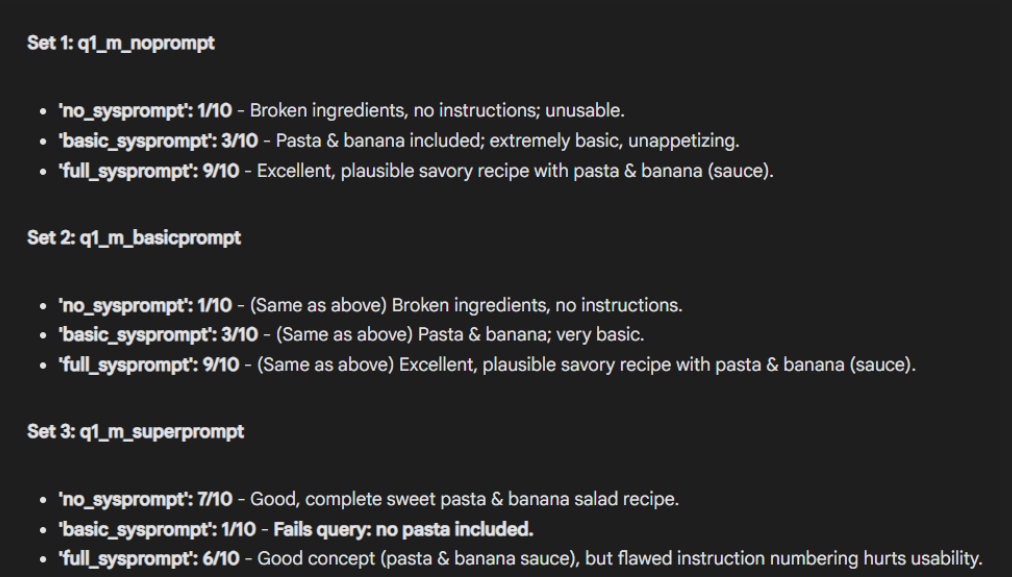

QUERY 2 : Give me a recipe to contain pasta and banana and not contain nuts and oranges

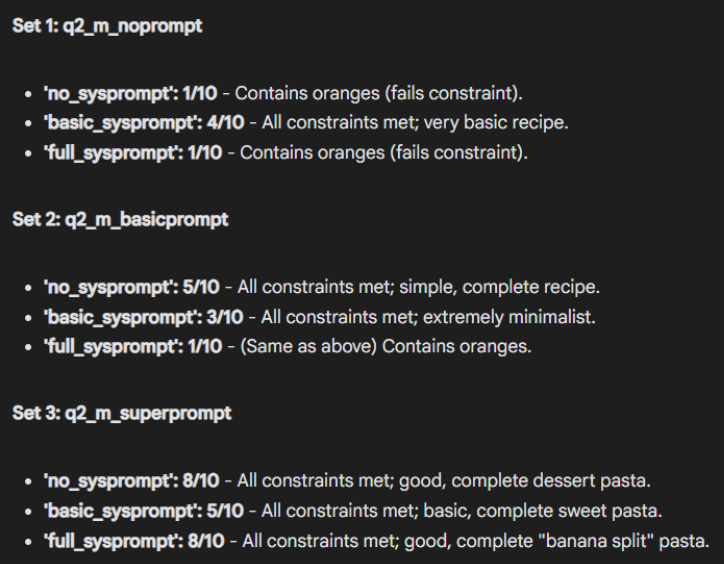

QUERY 3: Give me an recipe that contain rice and coconut milk and chicken and not contain peppers and wine

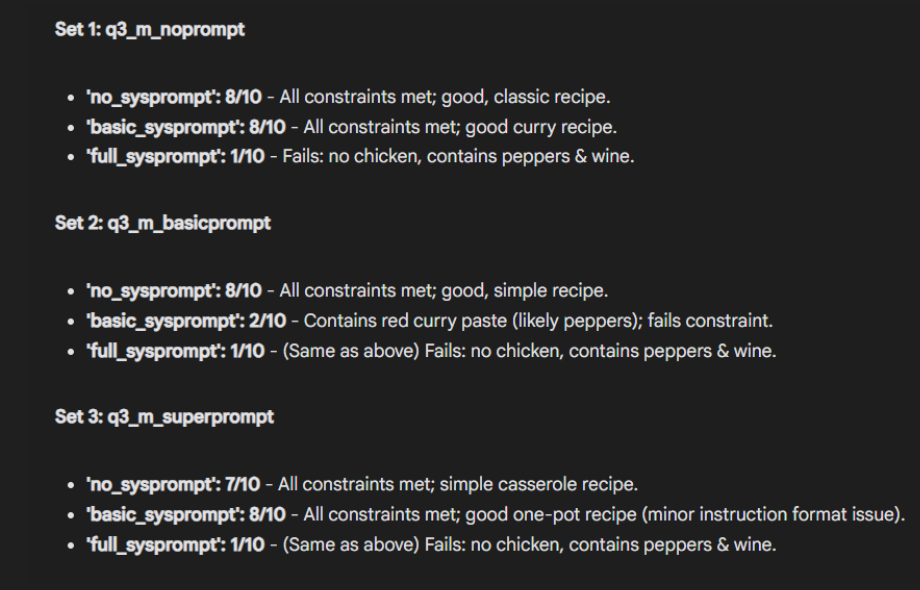

In [ ]:
import json

# Assuming `risposte` already contains all your dictionaries
with open("risposte.json", "w", encoding="utf-8") as f:
    json.dump(all_risposte, f, ensure_ascii=False, indent=4)